# Principal Component Analysis (PCA) and Neural Networks

# Principal component analysis (PCA)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


## Load or create a dataset with more than 2 dimensions.

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the data into 2D
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")


Training data shape: (60000, 784)
Test data shape: (10000, 784)


## Explore the data.

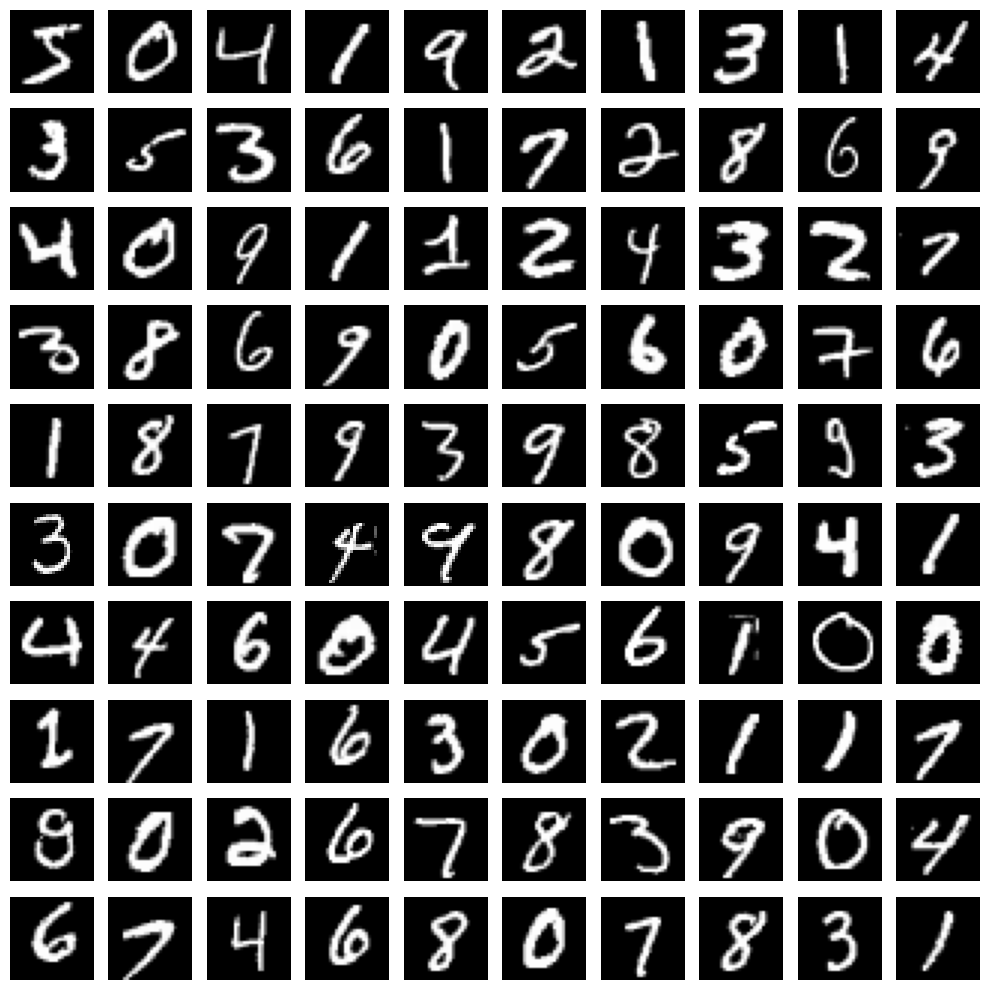

In [ ]:
def display_mnist_images(images, num_images=100, cmap='gray'):
    num_rows = int(np.sqrt(num_images))  # Calculate number of rows and columns for grid
    num_cols = num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_rows, num_cols))
    images = images.copy()
    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols

        # Reshape the image to (28, 28) before displaying
        image = images[i].reshape(28, 28)

        axes[row, col].imshow(image, cmap=cmap)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

display_mnist_images(x_train)

In [ ]:
# Step 1: Center the data
mean = np.mean(x_train, axis=0)
centered_data = x_train - mean

# Step 2: Compute the covariance matrix
covariance_matrix = np.cov(centered_data, rowvar=False)

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 4: Sort eigenvectors by eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
first_two_components = eigenvectors[:, sorted_indices[:2]]

# Step 5: Project the data onto the first two components
projected_data = np.dot(centered_data, first_two_components)

print(f"Shape of projected data: {projected_data.shape}")


Shape of projected data: (60000, 2)


## Find the first 2 principal components without using sklearn.

In [ ]:
pca = PCA(n_components=2)
projected_data_sklearn = pca.fit_transform(x_train)

print(f"Shape of projected data using sklearn: {projected_data_sklearn.shape}")


Shape of projected data using sklearn: (60000, 2)


## Find the first 2 principal components using sklearn.

In [ ]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the data
pca.fit(x_train_reshaped)

# Transform the data to the principal components
projected_data_sklearn = pca.transform(x_train_reshaped)

print("Projected data shape using sklearn:", projected_data_sklearn.shape)
print("First two principal components using sklearn:\n", pca.components_)

Projected data shape using sklearn: (60000, 2)
First two principal components using sklearn:
 [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


## Practice using PCA to preserve a certain percentage of variance.

In [ ]:
# Define a function to perform PCA with variance threshold
def pca_with_variance(data, n_components=None, variance_threshold=None, pca=None):
    # Added pca object as an argument

    if pca is None: # Initialize pca if not provided
        if n_components is not None:
            pca = PCA(n_components=n_components)
        elif variance_threshold is not None:
            pca = PCA(n_components=variance_threshold, svd_solver='full')  # Ensures correct interpretation
        else:
            pca = PCA()  # Keep all components if neither is specified
    else:
        pass # If pca object is provided, reuse the existing pca settings

    transformed_data = pca.fit_transform(data) if pca is not None and not hasattr(pca, 'components_') else pca.transform(data) # Fit if pca is new else transform
    return transformed_data, pca.n_components_, pca


# Get the number of components from x_train using the desired variance threshold
transformed_train, num_components, pca = pca_with_variance(x_train, variance_threshold=0.95)  # Store the fitted pca object
print(f"Number of components to preserve 95% variance: {num_components}")

Number of components to preserve 95% variance: 154


## Train a classification or regression neural network using original dataset

In [ ]:
# Define and train a neural network
def train_nn(input_shape, x_train, y_train, x_test, y_test, epochs=10):
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)  # Adjust batch size if needed
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_dataset, epochs=epochs, verbose=1)  # train_dataset is now a tf.data.Dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model, accuracy

# Train using original dataset
train_nn((x_train.shape[1],), x_train, y_train, x_test, y_test)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8798 - loss: 0.4289
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9609 - loss: 0.1336
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9738 - loss: 0.0889
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9818 - loss: 0.0630
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9856 - loss: 0.0478
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9899 - loss: 0.0355
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9938 - loss: 0.0265
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9945 - loss: 0.0210
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9955 - loss: 0.0174
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9961 - loss: 0.0138
Test Loss: 0.1010, Test Accuracy: 0.9765


(<Sequential name=sequential_7, built=True>, 0.9764999747276306)

## Train a classification or regression neural network using principal components

In [ ]:
transformed_train, num_components, _ = pca_with_variance(x_train, variance_threshold=0.95) # Unpack all three returned values
transformed_test, _, _ = pca_with_variance(x_test, variance_threshold=0.95, pca=_) # Reuse the fitted pca object and unpack all three returned values

train_nn((num_components,), transformed_train, y_train, transformed_test, y_test)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8378 - loss: 0.5998
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9616 - loss: 0.1336
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9758 - loss: 0.0847
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9833 - loss: 0.0593
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9888 - loss: 0.0434
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9926 - loss: 0.0322
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9952 - loss: 0.0237
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9974 - loss: 0.0172
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9987 - loss: 0.0122
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9993 - loss: 0.0083
Test Loss: 0.0869, Test Accuracy: 0.9767


(<Sequential name=sequential_8, built=True>, 0.9767000079154968)

## Train a classification or regression neural network using Kernel PCA (linear, sigmoid, RBF).

In [ ]:
def train_kernel_pca(
        x_train, y_train, x_test, y_test,
        kernels, gamma_values=None, n_components=10,
        epochs=5, subset_size=5000):
    # Reduce dataset size for training and testing
    x_train_small, y_train_small = x_train[:subset_size], y_train[:subset_size]
    x_test_small, y_test_small = x_test[:subset_size], y_test[:subset_size]

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_small)
    x_test_scaled = scaler.transform(x_test_small)

    for kernel in kernels:
        if kernel == 'rbf' and gamma_values:
            for gamma in gamma_values:
                kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components)

                print(f"Fitting Kernel PCA with kernel={kernel} and gamma={gamma}")
                x_train_kpca = kpca.fit_transform(x_train_scaled)
                x_test_kpca = kpca.transform(x_test_scaled)

                print(f"Training NN for kernel={kernel}, gamma={gamma}")
                train_nn((n_components,), x_train_kpca, y_train_small, x_test_kpca, y_test_small, epochs)
        else:
            kpca = KernelPCA(kernel=kernel, n_components=n_components)

            print(f"Fitting Kernel PCA with kernel={kernel}")
            x_train_kpca = kpca.fit_transform(x_train_scaled)
            x_test_kpca = kpca.transform(x_test_scaled)

            print(f"Training NN for kernel={kernel}")
            train_nn((n_components,), x_train_kpca, y_train_small, x_test_kpca, y_test_small, epochs)


# Run Kernel PCA training with reduced settings
kernels = ['linear', 'sigmoid', 'rbf']
gamma_values = [0.01, 0.1]  # Reduce gamma values to avoid overload
train_kernel_pca(x_train, y_train, x_test, y_test, kernels=kernels, gamma_values=gamma_values, n_components=10, epochs=5, subset_size=5000)


Fitting Kernel PCA with kernel=linear
Training NN for kernel=linear
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5658 - loss: 1.4416
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8265 - loss: 0.5706
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8551 - loss: 0.4856
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8694 - loss: 0.4357
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3996
Test Loss: 0.5155, Test Accuracy: 0.8342
Fitting Kernel PCA with kernel=sigmoid
Training NN for kernel=sigmoid
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4100 - loss: 2.2043
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6662 - loss: 1.5586
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7389 - loss: 1.0441
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7726 - loss: 0.8355
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc

## Build a pipeline to tune the hyperparameters of Kernel PCA and also the neural network. Which hyperparameters can be tuned?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Build a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA()),
    ('mlp', MLPClassifier(max_iter=100))
])


# Define parameter grid
param_grid = {
    'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
    'kpca__gamma': [0.01, 0.1, 1.0],
    'mlp__hidden_layer_sizes': [(100,), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001]
}


# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)


subset_size = 5000  # Choose a low size to avoid occupying the whole RAM leading to crashes
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]
grid_search.fit(x_train_subset, y_train_subset)


print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   9.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   7.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   7.5s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   7.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   6.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   7.5s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.001, m

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=  37.0s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=  36.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  22.5s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  23.7s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  25.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=  35.1s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=  33.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rb

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/skl

Best parameters: {'kpca__gamma': 0.1, 'kpca__kernel': 'linear', 'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 64)}
Best accuracy: 0.8941997914942822


# Classification problem

## source: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [ ]:
!pip install scikeras[tensorflow]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Perceptron
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import random
import torch

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) # If using GPU
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cudnn
torch.backends.cudnn.benchmark = False # Disable benchmarking for consistent results

## Load IRIS and MNIST fashion datasets from Keras.

### Load IRIS dataset.

In [5]:
# Source: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb


iris = load_iris()
X_iris = iris.data  # petal length, petal width
y_iris = iris.target

# Split the data into training, validation, and test sets
X_train_iris, X_temp_iris, y_train_iris, y_temp_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)
X_val_iris, X_test_iris, y_val_iris, y_test_iris = train_test_split(
    X_temp_iris, y_temp_iris, test_size=0.5, random_state=42
)

# One-hot encode the target variable using LabelBinarizer
lb = LabelBinarizer()
y_train_iris = lb.fit_transform(y_train_iris)
y_val_iris = lb.transform(y_val_iris)
y_test_iris = lb.transform(y_test_iris)

### Load MNIST fashion dataset.

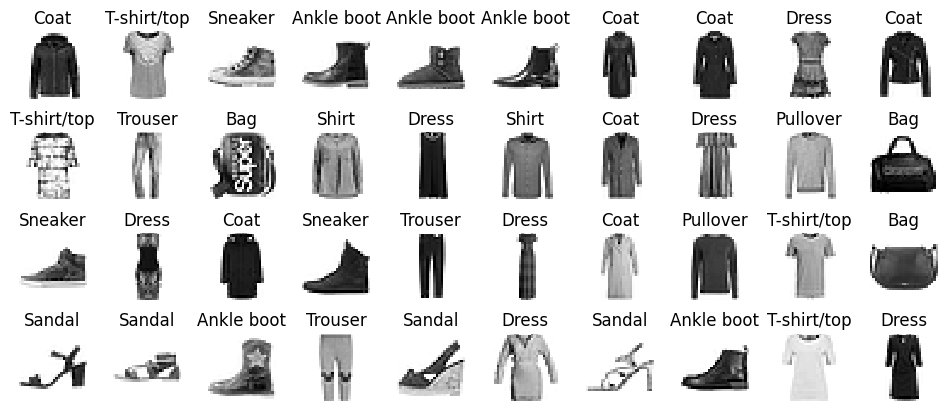

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train_fashion_full, y_train_fashion_full), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()
X_val_fashion, X_train_fashion = X_train_fashion_full[:5000] / 255., X_train_fashion_full[5000:] / 255.
y_val_fashion, y_train_fashion = y_train_fashion_full[:5000], y_train_fashion_full[5000:]
X_test_fashion = X_test_fashion / 255.

# One-hot encode the target variables
y_train_fashion_encoded = tf.keras.utils.to_categorical(y_train_fashion, num_classes=10)
y_val_fashion_encoded = tf.keras.utils.to_categorical(y_val_fashion, num_classes=10)
y_test_fashion_encoded = tf.keras.utils.to_categorical(y_test_fashion, num_classes=10)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_fashion[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train_fashion[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Build and train a neural network for classifying the loaded labeled datasets.

### Neural network for Iris dataset

In [26]:
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X_iris, y_iris)

y_pred = per_clf.predict(X_test_iris)

### Neural network for fashion MNIST dataset

#### Build the model.

In [9]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model.

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history_mnist_fashion = model.fit(X_train_fashion, y_train_fashion, epochs=30,
                    validation_data=(X_val_fashion, y_val_fashion))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6802 - loss: 1.0147 - val_accuracy: 0.8268 - val_loss: 0.5121
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8236 - loss: 0.5045 - val_accuracy: 0.8484 - val_loss: 0.4477
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8421 - loss: 0.4489 - val_accuracy: 0.8568 - val_loss: 0.4171
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8518 - loss: 0.4175 - val_accuracy: 0.8632 - val_loss: 0.3955
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8589 - loss: 0.3954 - val_accuracy: 0.8674 - val_loss: 0.3801
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8644 - loss: 0.3788 - val_accuracy: 0.8700 - val_loss: 0.3684
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8692 - loss: 0.3651 - val_accuracy: 0.8724 - val_loss: 0.3591
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8732 - loss: 0.35

## Tune the hyperparameters (including hidden layer size and activation functions). What else can be tuned?

### Clear session and set random seeds

In [13]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Define the function to build a neural network model

In [14]:
def build_model_iris(n_hidden=1, n_neurons=30, learning_rate=3e-3, activation='tanh', input_shape=(4,)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(3, activation="softmax")) # 3 output neurons for 3 classes
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


def build_model_fashion(n_hidden=1, n_neurons=30, learning_rate=3e-3, activation='tanh', input_shape=(28, 28)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    model.add(tf.keras.layers.Flatten()) # Input layer
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))  # 10 output neurons for 10 classes
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

### Use SciKeras to Wrap Keras Model as a Classifier

In [29]:
keras_clf_iris = KerasClassifier(model=build_model_iris)
keras_clf_fashion = KerasClassifier(model=build_model_fashion)

### Perform Randomized Search for Hyperparameter Tuning with Early Stopping

In [30]:
# parameter distributions for hidden layer size and activation function
param_distribs_fashion = {
    "model__n_hidden": [2, 3, 5, 7],
    "model__n_neurons": np.arange(1, 100).tolist(),
    "model__activation": ["swish", "mish"],
    "model__learning_rate": reciprocal(0.0001, 0.01).rvs(1000).tolist(),
}

rnd_search_cv_iris = RandomizedSearchCV(keras_clf_iris, param_distribs_fashion, n_iter=30, cv=3, verbose=2, error_score='raise', random_state=42)
rnd_search_cv_iris.fit(X_train_iris, y_train_iris, epochs=20,
                  validation_data=(X_val_iris, y_val_iris),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.3615 - loss: 1.0893 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3615 - loss: 1.0893 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3615 - loss: 1.0892 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3615 - loss: 1.0891 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3615 - loss: 1.0891 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3615 - loss: 1.0890 - val_accuracy: 0.2727 - val_loss: 1.1005
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3615 - loss: 1.0889 - val_accuracy: 0.2727 - val_loss: 1.1004
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=KerasClassifier(model=<function build_model_iris at 0x7d685456fd00>),
                   n_iter=30,
                   param_distributions={'model__activation': ['swish', 'mish'],
                                        'model__learning_rate': [0.0003337423867546693,
                                                                 0.00031185850896624744,
                                                                 0.006493953298280694,
                                                                 0.00031556759477955416,
                                                                 0.000349864157194575,
                                                                 0.0033021479292363524,
                                                                 0.0007...
                                                                 0.0013192781416439218,
                                                                 0.0074755805269149074,
                                                                 0.00012720839073892073,
                                                                 0.0006879971483464091,
                                                                 0.0003313718267582067,
                                                                 0.0028949557508575136,
                                                                 0.00917474877193901,
                                                                 0.0003258818138282188,
                                                                 0.002033991824391336, ...],
                                        'model__n_hidden': [2, 3, 5, 7],
                                        'model__n_neurons': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...]},
                   random_state=42, verbose=2)

In [92]:
# parameter distributions for hidden layer size and activation function
p_relu = keras.layers.PReLU()
param_distribs_fashion = {
    "model__n_hidden": [2, 3, 5, 7],
    "model__n_neurons": np.arange(1, 100).tolist(),
    "model__activation": ["swish", "mish", p_relu],
    "model__learning_rate": reciprocal(0.0001, 0.01).rvs(1000).tolist(),
}


rnd_search_cv_fashion = RandomizedSearchCV(keras_clf_fashion, param_distribs_fashion, n_iter=30, cv=3, verbose=2, error_score='raise', random_state=42)
rnd_search_cv_fashion.fit(X_train_fashion, y_train_fashion_encoded, epochs=8,
                  validation_data=(X_val_fashion, y_val_fashion_encoded),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0830 - loss: 2.3035 - val_accuracy: 0.0866 - val_loss: 2.3034
Epoch 2/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0902 - loss: 2.3031 - val_accuracy: 0.0912 - val_loss: 2.3030
Epoch 3/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0948 - loss: 2.3027 - val_accuracy: 0.0958 - val_loss: 2.3026
Epoch 4/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1014 - loss: 2.3024 - val_accuracy: 0.0970 - val_loss: 2.3023
Epoch 5/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1051 - loss: 2.3020 - val_accuracy: 0.0996 - val_loss: 2.3019
Epoch 6/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1089 - loss: 2.3016 - val_accuracy: 0.1008 - val_loss: 2.3015
Epoch 7/8
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1120 - loss: 2.3012 - val_accuracy: 0.1028 - val_loss: 2.3011
Epoch 8/8
1146/1146 ━━━━━━━━━━━━━━━━

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=KerasClassifier(model=<function build_model_fashion at 0x787786409cf0>),
                   n_iter=30,
                   param_distributions={'model__activation': ['swish', 'mish',
                                                              <PReLU name=p_re_lu, built=False>],
                                        'model__learning_rate': [0.001112997401719191,
                                                                 0.00023354848318673109,
                                                                 0.0003652219745642852,
                                                                 0.001076491448871813,
                                                                 0.00295139690094...
                                                                 0.00017788629055067278,
                                                                 0.00035806388540489024,
                                                                 0.0002770470376218992,
                                                                 0.0005750548326461524,
                                                                 0.0033642618526710296,
                                                                 0.002675569302577687,
                                                                 0.002113721771857465,
                                                                 0.00010293690157323777,
                                                                 0.00019243613547292017, ...],
                                        'model__n_hidden': [2, 3, 5, 7],
                                        'model__n_neurons': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...]},
                   random_state=42, verbose=2)

### Train optimal model

In [32]:
best_params_iris = rnd_search_cv_iris.best_params_
best_val_accuracy_iris = rnd_search_cv_iris.best_score_
print(best_params_iris)
print(best_val_accuracy_iris)

model_iris = build_model_iris(
    n_hidden=best_params_iris['model__n_hidden'],
    n_neurons=best_params_iris['model__n_neurons'],
    learning_rate=best_params_iris['model__learning_rate'],
    activation=best_params_iris['model__activation'],
    input_shape=(4,)
)

scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history_iris = model_iris.fit(
                   X_train_iris, y_train_iris, epochs=300,
                   validation_data=(X_val_iris, y_val_iris),
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
                       tf.keras.callbacks.ModelCheckpoint(
                           'best_model.keras',
                           save_best_only=True,
                           monitor='val_loss',
                        ),
                       scheduler,
                   ]
                )

{'model__n_neurons': 41, 'model__n_hidden': 3, 'model__learning_rate': 0.005531310883573675, 'model__activation': 'mish'}
0.6857142857142856
Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3420 - loss: 1.6313 - val_accuracy: 0.1364 - val_loss: 1.2560 - learning_rate: 0.0055
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3316 - loss: 1.2615 - val_accuracy: 0.5455 - val_loss: 1.1053 - learning_rate: 0.0055
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4648 - loss: 1.1477 - val_accuracy: 0.6818 - val_loss: 1.0430 - learning_rate: 0.0055
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4443 - loss: 1.0936 - val_accuracy: 0.7727 - val_loss: 1.0089 - learning_rate: 0.0055
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4571 - loss: 1.0593 - val_accuracy: 0.8182 - val_loss: 0.9850 - learning_rate: 0.0055
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5619 - loss: 1.0329 - val_accuracy: 0.8636 - 

In [21]:
best_params_fashion = rnd_search_cv_fashion.best_params_
best_val_accuracy_fashion = rnd_search_cv_fashion.best_score_
print(best_params_fashion)
print(best_val_accuracy_fashion)



model_fashion = build_model_fashion(
    n_hidden=best_params_fashion['model__n_hidden'],
    n_neurons=best_params_fashion['model__n_neurons'],
    learning_rate=best_params_fashion['model__learning_rate'],
    activation=best_params_fashion['model__activation'],
    input_shape=(28, 28)
)


scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history_fashion = model_fashion.fit(
                   X_train_fashion, y_train_fashion_encoded, epochs=300,
                   validation_data=(X_val_fashion, y_val_fashion_encoded),
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
                       tf.keras.callbacks.ModelCheckpoint(
                           'best_model.keras',
                           save_best_only=True,
                           monitor='val_loss',
                        ),
                       scheduler,
                   ]
                )

Epoch 1/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1903 - loss: 2.2675 - val_accuracy: 0.3846 - val_loss: 2.1026 - learning_rate: 7.8000e-04
Epoch 2/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3870 - loss: 1.9454 - val_accuracy: 0.5170 - val_loss: 1.3369 - learning_rate: 7.8000e-04
Epoch 3/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5826 - loss: 1.2143 - val_accuracy: 0.6902 - val_loss: 0.8903 - learning_rate: 7.8000e-04
Epoch 4/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7027 - loss: 0.8514 - val_accuracy: 0.7542 - val_loss: 0.7238 - learning_rate: 7.8000e-04
Epoch 5/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7464 - loss: 0.7155 - val_accuracy: 0.7726 - val_loss: 0.6493 - learning_rate: 7.8000e-04
Epoch 6/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7705 - loss: 0.6493 - val_accuracy: 0.7892 - val_loss: 0.6055 - learning_rate: 7.8000e-04
Epoch 7/300
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s

### Plot hiatory (Iris).

In [22]:
def plot_learning_clf(history_df):
    # Plot R2 score
    plt.figure(figsize=(10, 5))
    plt.plot(history_df['accuracy'], label='Training Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.2)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history_df['loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

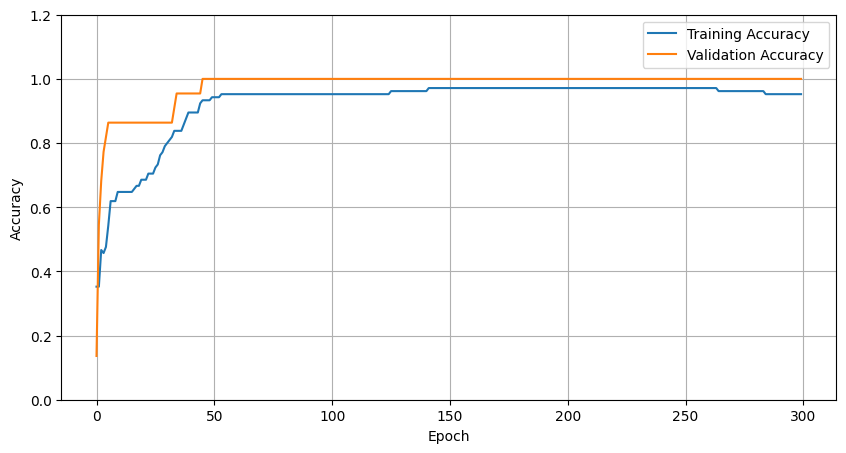

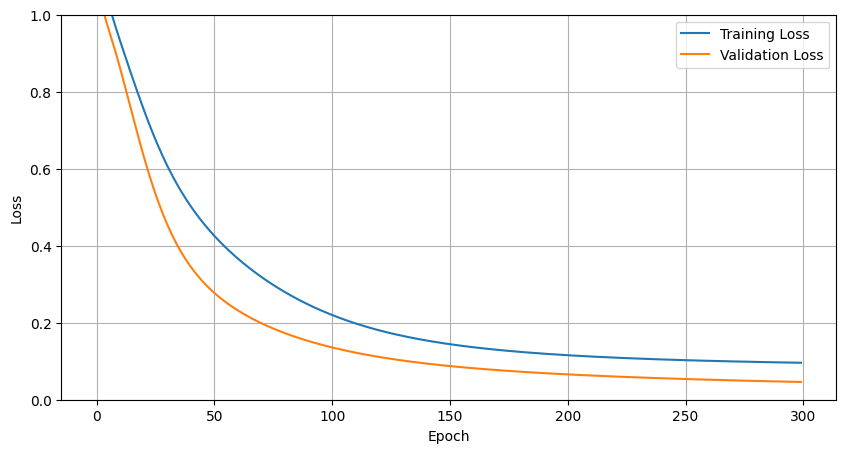

In [33]:
# Plot the training and validation accuracy over epochs
plot_learning_clf(history_iris.history)

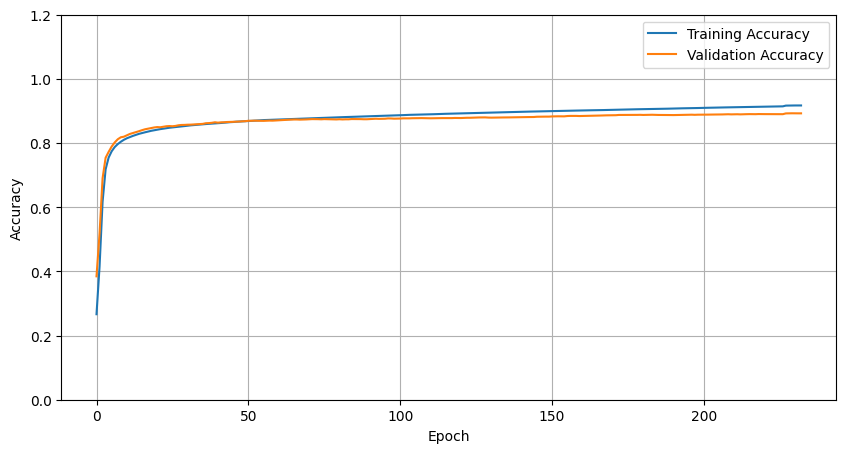

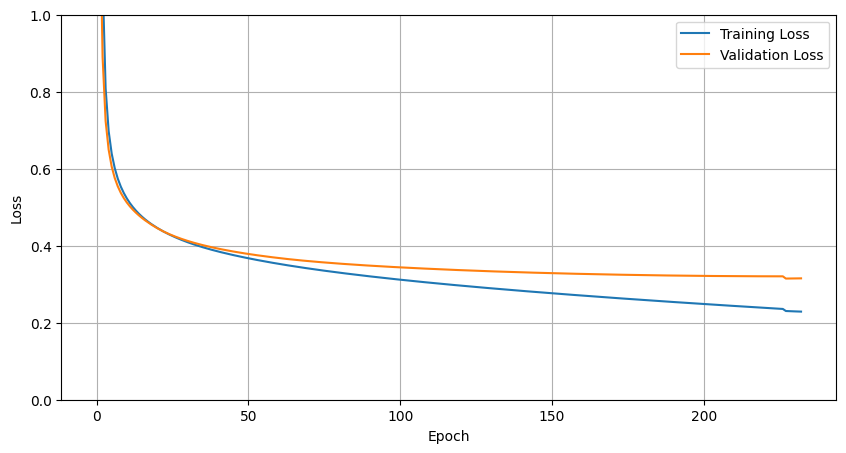

In [24]:
# Plot the training and validation accuracy over epochs
plot_learning_clf(history_fashion.history)

# Regression problem

## Load California housing dataset and split it to training and testing datasets.

## Clone the repository.

In [ ]:
!git clone https://github.com/ageron/handson-ml2.git

Cloning into 'handson-ml2'...
remote: Enumerating objects: 3100, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3100 (delta 0), reused 1 (delta 0), pack-reused 3096 (from 1)
Receiving objects: 100% (3100/3100), 150.92 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (1905/1905), done.


## Import the libraries required.

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

## Load the dataset.

In [ ]:
housing = pd.read_csv('/content/handson-ml2/datasets/housing/housing.csv')
data, labels = housing.drop('median_house_value', axis=1), housing['median_house_value']
# Split the data into training and testing

stratify = pd.qcut(labels, q=20, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
                                        data,
                                        labels,
                                        test_size=0.2,
                                        stratify=stratify,
                                        random_state=42,
                                    )

stratify = pd.qcut(y_train, q=20, labels=False)

# Split the training set into train_part and val_part
X_train, X_val, y_train, y_val = train_test_split(
                                                         X_train,
                                                         y_train,
                                                         test_size=0.2,
                                                         stratify=stratify,
                                                         random_state=42
                                                     )

## Preprocess the data.

### Define transformers.

In [ ]:
#Souces: https://github.com/omisa69/IAI600Lab2, https://github.com/omisa69/IAI600Lab6

# Feature Engineering using Transformation

# Providing Additional Features (Ratio Features)
class RatioFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, names):
        self.names = names

    def fit(self, X, y=None):
        self.feature_names_in_ = self.names
        return self

    def transform(self, X):
        transformed_X = X[:, 0] / X[:, 1]
        return transformed_X.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return [f'{self.names[0]}_per_{self.names[1]}']


# LogTransformer
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist() if hasattr(X, 'columns') else None
        return self

    def transform(self, X):
        return np.log1p(X)

    def get_feature_names_out(self, input_features=None):
        if input_features is None and self.feature_names_in_:
            input_features = self.feature_names_in_
        return [f'log_{feature}' for feature in input_features]


# GeoTransformer
class GeoTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(
                X,
                columns=['median_income', 'latitude', 'longitude']
            )
        self.feature_names_in_ = X.columns.tolist()

        log_pipeline = make_pipeline(
            SimpleImputer(strategy='median'),
            FunctionTransformer(
                np.log1p,
                inverse_func=np.expm1,
                validate=True
            ),
            StandardScaler(),
        )

        geo_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
        preprocessing = ColumnTransformer([
            ('log_kmeans', log_pipeline, ['median_income']),
            ('geo_kmeans', geo_pipeline, ['latitude', 'longitude']),
        ])

        X_transformed = pd.DataFrame(preprocessing.fit_transform(X))
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X_transformed, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f'geo_feature_{i}' for i in range(self.n_clusters)]

num_imputer = SimpleImputer(strategy='median')  # Numerical missing values
cat_imputer = SimpleImputer(strategy='most_frequent') # Categorical missing values; ocean_proximity
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Handle text and categorical attributes; ocean_proximity
ratio_feature_transformer = RatioFeatureTransformer([]) # # Provide additional features (ratio features)
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True) # Transform heavy-tailed features # total_rooms, total_bedrooms, population, households, median_income
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0) # Transform features with multiple distributions; # housing_median_age
geo_transformer = GeoTransformer(n_clusters=4, random_state=42) # Transform geographical features

### Make pipeline.

In [ ]:
log_pipeline = make_pipeline(num_imputer, LogTransformer(), StandardScaler())  # Pipeline for Heavy-Tailed Features
geo_pipeline = make_pipeline(num_imputer, geo_transformer, cat_encoder, StandardScaler())  # Pipeline for Geographical Features
quantile_pipeline = make_pipeline(num_imputer, quantile_transformer, StandardScaler())  # Pipeline for Multiple Distributions
ratio_feature_pipeline = make_pipeline(num_imputer, ratio_feature_transformer, StandardScaler())  # Pipeline for Additional Features (Ratio Features)

# Create separate pipelines for each ratio feature
bedrooms_pipeline = make_pipeline(num_imputer, RatioFeatureTransformer(['total_bedrooms', 'total_rooms']), StandardScaler())
rooms_per_house_pipeline = make_pipeline(num_imputer, RatioFeatureTransformer(['total_rooms', 'households']), StandardScaler())
people_per_house_pipeline = make_pipeline(num_imputer, RatioFeatureTransformer(['population', 'households']), StandardScaler())

cat_pipeline = make_pipeline(cat_imputer, cat_encoder, StandardScaler()) # Pipeline for Categorical Features

### Preprocess the data

In [ ]:
preprocessing = ColumnTransformer([
    ('bedrooms', bedrooms_pipeline, ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', rooms_per_house_pipeline, ['total_rooms', 'households']),
    ('people_per_house', people_per_house_pipeline, ['population', 'households']),
    ('log', log_pipeline, ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']),
    ('geo', geo_pipeline, ['latitude', 'longitude', 'median_income']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ('qt_age', quantile_pipeline, ['housing_median_age']),
])

X_train_transformed = preprocessing.fit_transform(X_train)
X_val_transformed = preprocessing.transform(X_val)
X_test_transformed = preprocessing.transform(X_test)

label_pipeline = make_pipeline(num_imputer, StandardScaler())

y_train_transformed = label_pipeline.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val_transformed = label_pipeline.transform(y_val.to_numpy().reshape(-1, 1))
y_test_transformed = label_pipeline.transform(y_test.to_numpy().reshape(-1, 1))

## Build and train a neural network for price prediction. Tune the hyperparameters and discuss the results.

### Define the Neural Network Model

In [ ]:
# Source: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


### Initialize the model

In [ ]:
input_dim = X_train_transformed.shape[1]  # Number of features
model = RegressionModel(input_dim)

### Create DataLoaders to handle batching and shuffling of the dataset

In [ ]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_transformed, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_transformed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_transformed, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Define a function calculating $r^2$ score.

In [ ]:
def r2_score(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()



### Train the model

In [ ]:
loss_fn = nn.MSELoss()  # Use Mean Squared Error (MSE) as the Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Choose optimizer
epochs = 20
torch.autograd.set_detect_anomaly(True)
history = []
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_r2 = 0.0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = loss_fn(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r2 += r2_score(outputs, batch_targets)
    train_loss /= len(train_loader)
    train_r2 /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_r2 = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            loss = loss_fn(val_outputs, val_targets)
            val_loss += loss.item()
            val_r2 += r2_score(val_outputs, val_targets)
    val_loss /= len(val_loader)
    val_r2 /= len(val_loader)
    history.append((train_loss, val_loss, train_r2, val_r2))
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training R2: {train_r2:.4f}, Validation R2: {val_r2:.4f}')


Epoch 1/20, Training Loss: 0.3730, Validation Loss: 0.4103, Training R2: 0.6001, Validation R2: 0.5829
Epoch 2/20, Training Loss: 0.4868, Validation Loss: 0.3021, Training R2: 0.4683, Validation R2: 0.6750
Epoch 3/20, Training Loss: 0.2837, Validation Loss: 0.2896, Training R2: 0.6956, Validation R2: 0.6885
Epoch 4/20, Training Loss: 0.2795, Validation Loss: 0.2980, Training R2: 0.7010, Validation R2: 0.6835
Epoch 5/20, Training Loss: 0.2830, Validation Loss: 0.2883, Training R2: 0.7016, Validation R2: 0.6919
Epoch 6/20, Training Loss: 0.2687, Validation Loss: 0.2828, Training R2: 0.7139, Validation R2: 0.6925
Epoch 7/20, Training Loss: 0.2656, Validation Loss: 0.2747, Training R2: 0.7148, Validation R2: 0.7013
Epoch 8/20, Training Loss: 0.2680, Validation Loss: 0.2795, Training R2: 0.7139, Validation R2: 0.6924
Epoch 9/20, Training Loss: 0.2627, Validation Loss: 0.2780, Training R2: 0.7166, Validation R2: 0.6937
Epoch 10/20, Training Loss: 0.2646, Validation Loss: 0.2809, Training R2:

## Plot the network history.

In [ ]:
def plot_training_history(history_df):
    # Plot R2 score
    plt.figure(figsize=(10, 5))
    plt.plot(history_df['train_r2'], label='Training R2')
    plt.plot(history_df['val_r2'], label='Validation R2')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.2)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history_df['train_loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

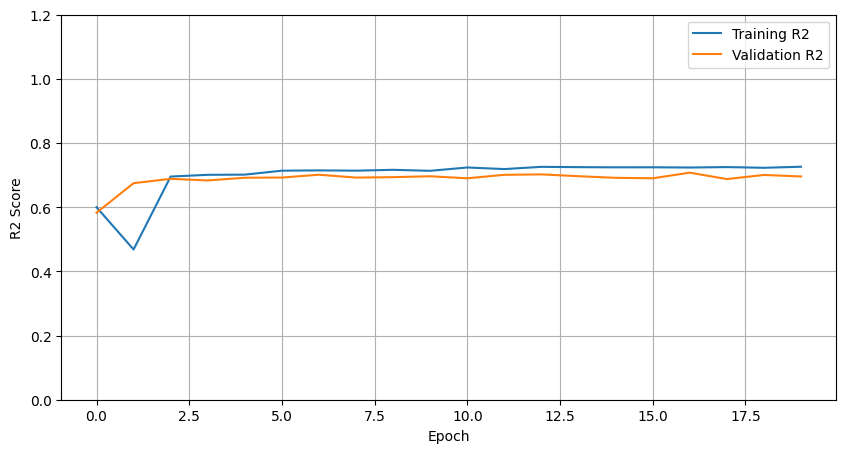

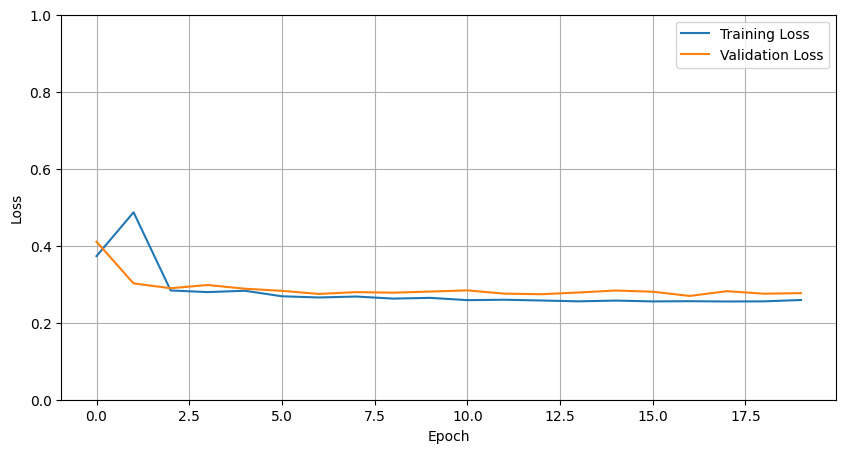

In [ ]:
history_df = pd.DataFrame(history, columns=['train_loss', 'val_loss', 'train_r2', 'val_r2'])
plot_training_history(history_df)

## Change the learning rate. Train the network again and plot the network history. Discuss the results.

In [ ]:
# Reinitialize the model
input_dim = X_train_transformed.shape[1]  # Number of features
model = RegressionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Choose optimizer
epochs = 20
history = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_r2 = 0.0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = loss_fn(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r2 += r2_score(outputs, batch_targets)
    train_loss /= len(train_loader)
    train_r2 /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_r2 = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            loss = loss_fn(val_outputs, val_targets)
            val_loss += loss.item()
            val_r2 += r2_score(val_outputs, val_targets)
    val_loss /= len(val_loader)
    val_r2 /= len(val_loader)
    history.append((train_loss, val_loss, train_r2, val_r2))
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training R2: {train_r2:.4f}, Validation R2: {val_r2:.4f}')

Epoch 1/20, Training Loss: 0.3969, Validation Loss: 0.2989, Training R2: 0.5504, Validation R2: 0.6751
Epoch 2/20, Training Loss: 0.2833, Validation Loss: 0.2847, Training R2: 0.6958, Validation R2: 0.6922
Epoch 3/20, Training Loss: 0.2744, Validation Loss: 0.2843, Training R2: 0.7090, Validation R2: 0.6921
Epoch 4/20, Training Loss: 0.2723, Validation Loss: 0.2775, Training R2: 0.7091, Validation R2: 0.6978
Epoch 5/20, Training Loss: 0.2662, Validation Loss: 0.2755, Training R2: 0.7131, Validation R2: 0.6979
Epoch 6/20, Training Loss: 0.2651, Validation Loss: 0.2947, Training R2: 0.7181, Validation R2: 0.6869
Epoch 7/20, Training Loss: 0.2592, Validation Loss: 0.2748, Training R2: 0.7221, Validation R2: 0.6996
Epoch 8/20, Training Loss: 0.2593, Validation Loss: 0.2757, Training R2: 0.7200, Validation R2: 0.7035
Epoch 9/20, Training Loss: 0.2545, Validation Loss: 0.2733, Training R2: 0.7263, Validation R2: 0.7036
Epoch 10/20, Training Loss: 0.2551, Validation Loss: 0.2749, Training R2:

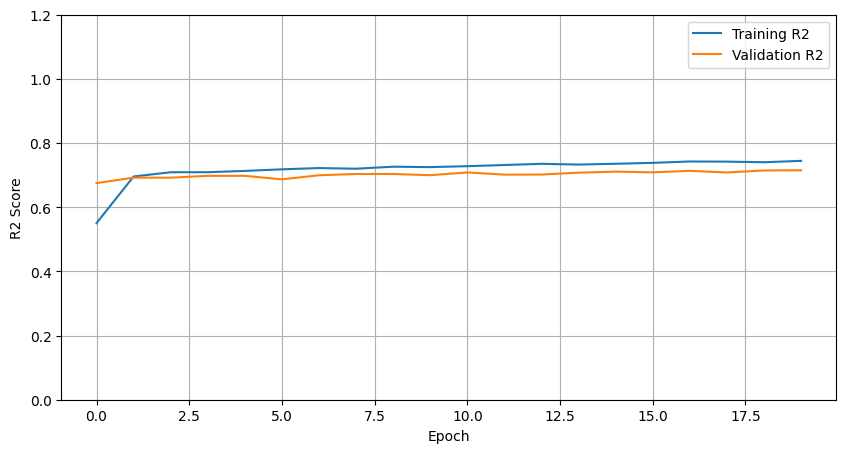

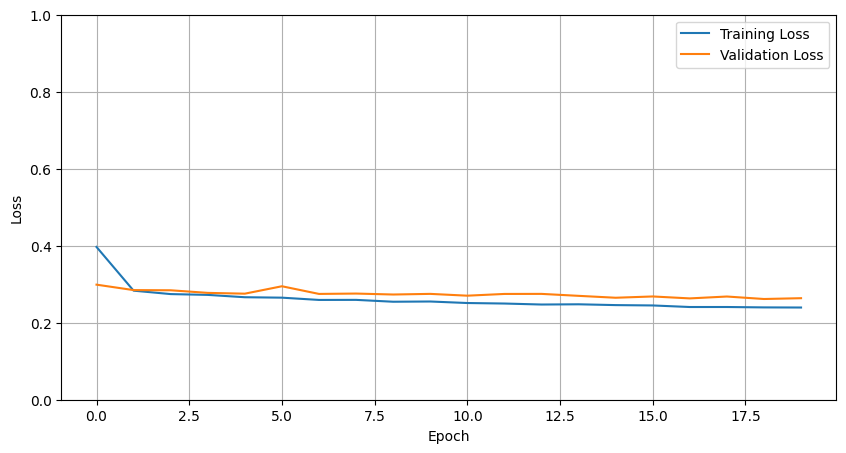

In [ ]:
history_df = pd.DataFrame(history, columns=['train_loss', 'val_loss', 'train_r2', 'val_r2'])
plot_training_history(history_df)

## Save the weights of the layers and use callbacks during the training process.

In [ ]:
# Define a directory to save the model weights
save_dir = '/content/model_weights'  # Saving path
os.makedirs(save_dir, exist_ok=True)

# Redefine the model and reload the data
# Create a model
input_dim = X_train_transformed.shape[1]  # Number of features
model = RegressionModel(input_dim)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Choose optimizer
epochs = 40
history_saving_weights = []


# Define a callback function to save model weights after each epoch
def save_model_weights(epoch, model, save_dir):
    file_path = os.path.join(save_dir, f'model_weights_epoch_{epoch}.pth')
    torch.save(model.state_dict(), file_path)

scheduler = ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=3,
                threshold=0.0001,
                threshold_mode='rel',
                cooldown=0,
                min_lr=0,
                eps=1e-08
            )
# Train the model
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_r2 = 0.0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = loss_fn(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r2 += r2_score(outputs, batch_targets)
    train_loss /= len(train_loader)
    train_r2 /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_r2 = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            loss = loss_fn(val_outputs, val_targets)
            val_loss += loss.item()
            val_r2 += r2_score(val_outputs, val_targets)
    val_loss /= len(val_loader)
    val_r2 /= len(val_loader)
    history_saving_weights.append((train_loss, val_loss, train_r2, val_r2))

    # Save model weights after each epoch
    save_model_weights(epoch, model, save_dir)

    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training R2: {train_r2:.4f}, Validation R2: {val_r2:.4f}')

Epoch 1/40, Training Loss: 0.3828, Validation Loss: 0.3399, Training R2: 0.5978, Validation R2: 0.6455
Epoch 2/40, Training Loss: 0.2955, Validation Loss: 0.2860, Training R2: 0.6845, Validation R2: 0.6934
Epoch 3/40, Training Loss: 0.2752, Validation Loss: 0.2827, Training R2: 0.7072, Validation R2: 0.6934
Epoch 4/40, Training Loss: 0.2741, Validation Loss: 0.2867, Training R2: 0.7009, Validation R2: 0.6922
Epoch 5/40, Training Loss: 0.2704, Validation Loss: 0.2807, Training R2: 0.7120, Validation R2: 0.6966
Epoch 6/40, Training Loss: 0.2665, Validation Loss: 0.2810, Training R2: 0.7160, Validation R2: 0.6957
Epoch 7/40, Training Loss: 0.2629, Validation Loss: 0.2755, Training R2: 0.7192, Validation R2: 0.7033
Epoch 8/40, Training Loss: 0.2633, Validation Loss: 0.2852, Training R2: 0.7168, Validation R2: 0.6882
Epoch 9/40, Training Loss: 0.2609, Validation Loss: 0.2739, Training R2: 0.7194, Validation R2: 0.7038
Epoch 10/40, Training Loss: 0.2568, Validation Loss: 0.2731, Training R2:

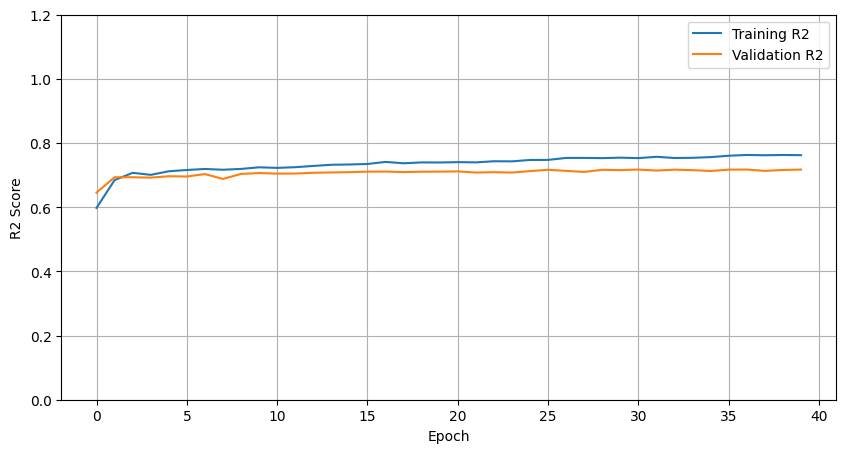

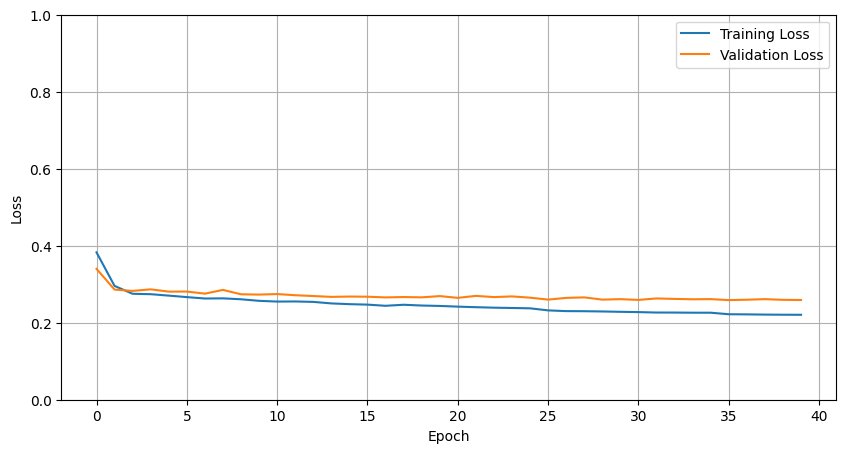

In [ ]:
history_df_saving_weights = pd.DataFrame(history_saving_weights, columns=['train_loss', 'val_loss', 'train_r2', 'val_r2'])
plot_training_history(history_df_saving_weights)

## Practice saving and loading the trained model.

In [ ]:
# Load the saved model weights

class NewRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(NewRegressionModel, self).__init__()
        self.network = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        )
    def forward(self, x):
        # Define the forward pass
        x = self.network(x)
        return x

input_dim = X_train_transformed.shape[1]  # Number of features
model = NewRegressionModel(input_dim)

# Load the saved model weights
model_path = '/content/model_weights/model_weights_epoch_4.pth'  # The path to the saved weights
model.load_state_dict(torch.load(model_path))

<ipython-input-28-554e3a0de8a5>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>